In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Number of samples:  788


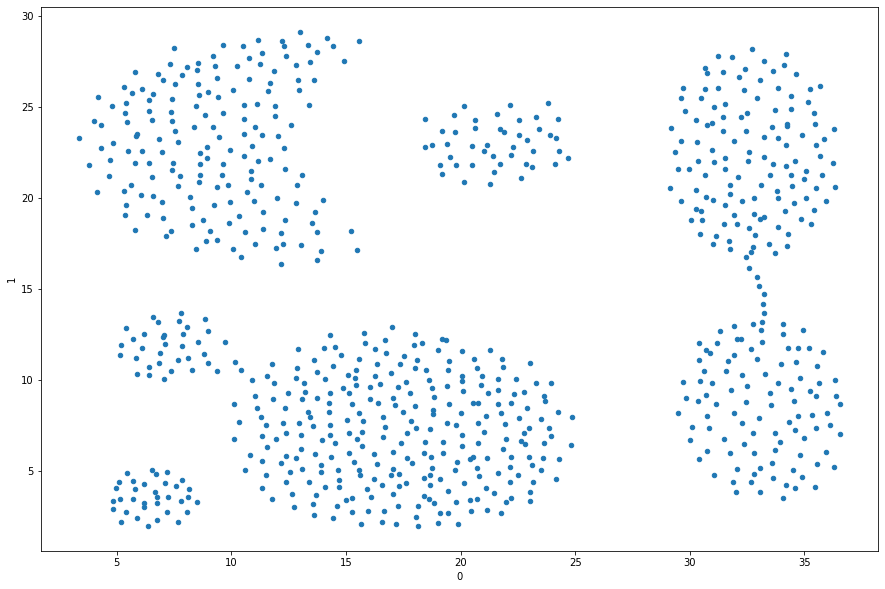

In [3]:
data = pd.read_csv('data.csv', header=None)
print('Number of samples: ',len(data))
data.plot.scatter(0, 1, figsize=(15, 10))
plt.show()

data = data.values

In [4]:
# normalization
mean = data.mean()
std = data.std()
data = (data - mean) / std

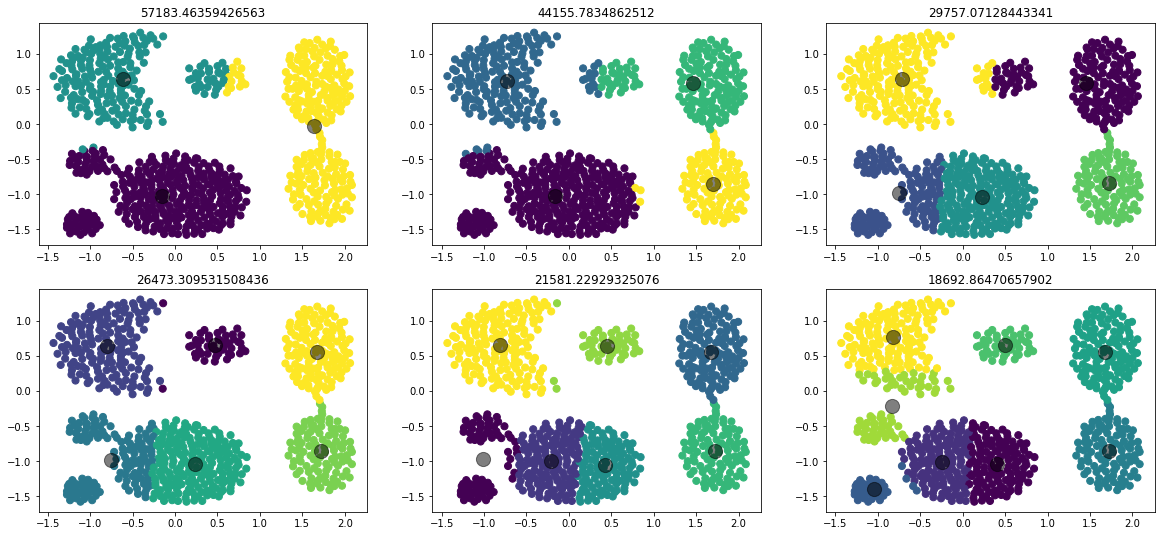

In [19]:
# DBI
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import make_scorer

from sklearn.cluster import KMeans

def DB_loss_function(estimator, X, y_true=None):
    """
    Computes Davis-Bolding Index for a fitted KMeans

    args:
        model: Fitted KMeans object
        x: input data for evaluation 
    """
    preds = estimator.predict(X)
    n_clusters = int(np.max(preds))+1

    db_values = []
    for i in range(n_clusters):
        for j in range(i+1, n_clusters):
            cluster_i = X[preds == i]
            cluster_j = X[preds == j]
            
            avg_cluster_i = 2 * np.sum(euclidean_distances(cluster_i, cluster_i)) / len(cluster_i)*(len(cluster_i)-1)
            avg_cluster_j = 2 * np.sum(euclidean_distances(cluster_j, cluster_j)) / len(cluster_j)*(len(cluster_j)-1)

            u_cluster_i = np.sum(cluster_i, axis=0) / len(cluster_i)
            u_cluster_j = np.sum(cluster_j, axis=0) / len(cluster_j)
            db = (avg_cluster_i + avg_cluster_j) / np.sum(euclidean_distances(
                u_cluster_i.reshape(-1,1), 
                u_cluster_j.reshape(-1,1)))
            db_values.append(db)
    dbi = np.sum(np.array(db_values)) / n_clusters
    return dbi

DBI_Scorer = make_scorer(DB_loss_function, greater_is_better=False)

n_clusters = np.arange(3, 9) 
plt.figure(figsize=(20, 9))

for i, n in enumerate(n_clusters):
    kmeans = KMeans(n_clusters=n, init='random')
    kmeans.fit(data)
    y_kmeans = kmeans.predict(data)

    plt.subplot(2, 3, i+1)
    plt.scatter(data[:, 0], data[:, 1], c=y_kmeans, s=50, cmap='viridis')

    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
    plt.title(DB_loss_function(kmeans, data))
plt.show()

In [ ]:
# grid search model training

from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV

parameters = {'n_clusters':list(np.arange(3, 10)), 'init':['random'], 
              'algorithm':('elkan', 'full'), 'tol':[0.0001, 0.001, 0.00005, 0.00001, 0.0005], 'max_iter':[300, 1000]}

best_model = None
best_score = np.inf

for n_c in parameters['n_clusters']:
    for al in parameters['algorithm']:
        for t in parameters['tol']:
            for i in parameters['max_iter']:
                kmeans = KMeans(**{'n_clusters':n_c, 'algorithm':al, 'tol': t, 'init': 'random', 'max_iter': i})
                kmeans.fit(data)
                dbi = DB_loss_function(kmeans, data)
                if dbi < best_score:
                    print('model config: ', str(kmeans), '\n', 'dbi score:', dbi)
                    best_score = dbi
                    best_model = kmeans
best_model

model config:  KMeans(algorithm='elkan', copy_x=True, init='random', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0) 
 dbi score: 57183.46359426563
model config:  KMeans(algorithm='full', copy_x=True, init='random', max_iter=300, n_clusters=3,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=None,
       tol=0.0001, verbose=0) 
 dbi score: 57081.73694047507
model config:  KMeans(algorithm='elkan', copy_x=True, init='random', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0) 
 dbi score: 44155.783486251195
model config:  KMeans(algorithm='elkan', copy_x=True, init='random', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=5e-05, verbose=0) 
 dbi score: 43970.91716060179
model config:  KMeans(algorithm='elkan', copy_x=True,

KMeans(algorithm='elkan', copy_x=True, init='random', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0005, verbose=0)

In [ ]:
best_model

KMeans(algorithm='elkan', copy_x=True, init='random', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0005, verbose=0)

13690.561580760907

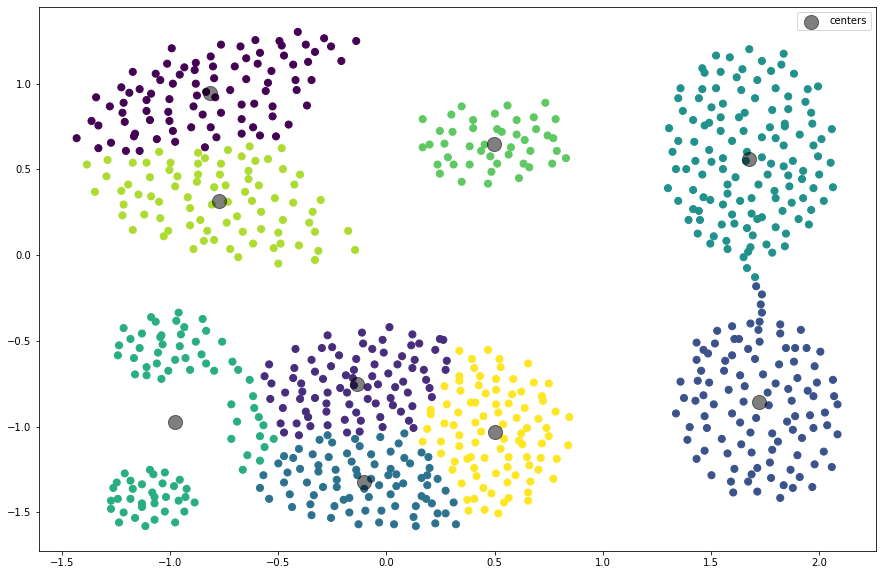

In [ ]:
y_kmeans = best_model.predict(data)

plt.figure(figsize=(15, 10))
plt.scatter(data[:, 0], data[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = best_model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5, label='centers')
plt.legend()

DB_loss_function(best_model, data)